In [1]:
import tomllib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interpn

import AEIC.trajectories.builders as tb
from AEIC.config import Config, config
from AEIC.missions import Mission
from AEIC.performance.models import PerformanceModel
from AEIC.performance.models.legacy import ROCDFilter
from AEIC.trajectories import TrajectoryStore, GroundTrack
from AEIC.storage import Dimension

Default configuration.

In [2]:
Config.load();

Sample performance model (updated: single mass for descent) and a performance model built from a randomly selected PTF file.

In [3]:
pm1 = PerformanceModel.load(config.file_location('performance/sample_performance_model.toml'))

In [4]:
pm2 = PerformanceModel.load(config.file_location('performance/random_test_ptf.toml'))

Built-in sample missions.

In [5]:
missions_file = config.file_location('missions/sample_missions_10.toml')
with open(missions_file, 'rb') as f:
    mission_dict = tomllib.load(f)
sample_missions = Mission.from_toml(mission_dict)

Pick a single mission to fly.

In [6]:
mission_idx = 2

Fly mission with legacy trajectory builder.

In [7]:
builder = tb.LegacyBuilder(options=tb.Options(iterate_mass=False))
mis = sample_missions[mission_idx]
traj1 = builder.fly(pm1, mis)
traj2 = builder.fly(pm2, mis)

Load golden test comparison trajectory.

In [8]:
with TrajectoryStore.open(base_file='../tests/data/golden/test_trajectories_golden.nc') as ts:
    golden = ts[mission_idx]

Comparison plots: see comments below.

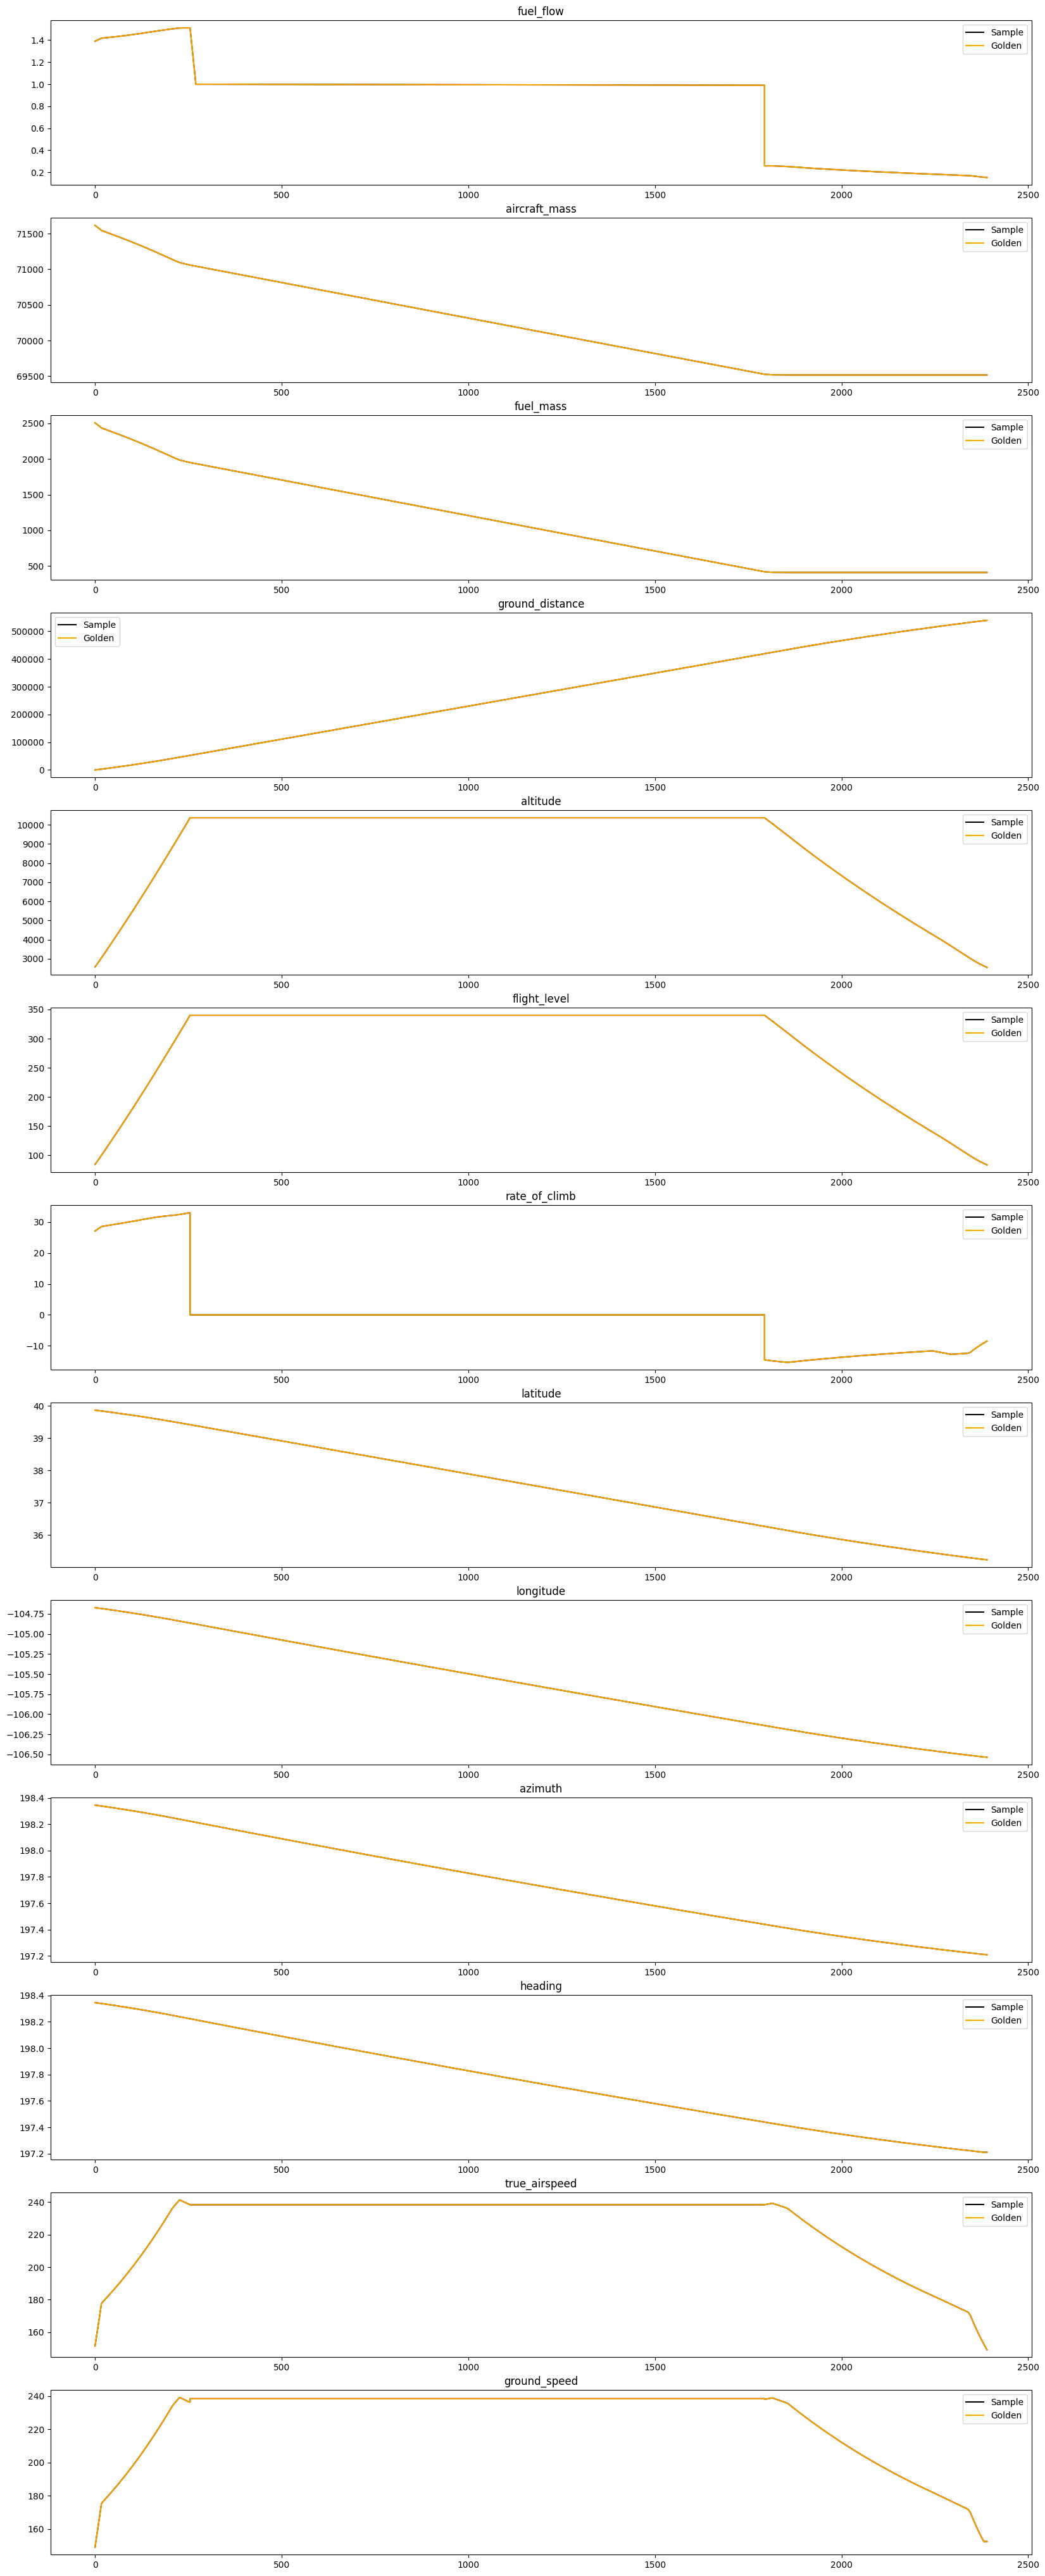

In [9]:
attrs = [
    'fuel_flow',
    'aircraft_mass',
    'fuel_mass',
    'ground_distance',
    'altitude',
    'flight_level',
    'rate_of_climb',
    'latitude',
    'longitude',
    'azimuth',
    'heading',
    'true_airspeed',
    'ground_speed',
]
fig, axs = plt.subplots(len(attrs), 1, figsize=(20, 4 * len(attrs)))
for i, a in enumerate(attrs):
    axs[i].plot(traj1.flight_time, getattr(traj1, a), color='black', label='Sample')
    # axs[i].plot(traj2.flight_time, getattr(traj2, a), color='grey', label='Random PTF')
    axs[i].plot(golden.flight_time, getattr(golden, a), color='orange', label='Golden')
    axs[i].set_title(a)
    axs[i].legend()

The simulations flown using a performance model built from a randomly selected PTF file are different from those using the sample performance model, as you'd expect.

The simulations flown with the sample performance model should match the golden test data.

In [10]:
start_idx = 195
end_idx = 205
df = pd.DataFrame({
    'new_time': traj1.flight_time[start_idx:end_idx],
    'old_time': golden.flight_time[start_idx:end_idx],
    'new_alt': traj1.altitude[start_idx:end_idx],
    'old_alt': golden.altitude[start_idx:end_idx],
    'new_lat': traj1.latitude[start_idx:end_idx],
    'old_lat': golden.latitude[start_idx:end_idx]
})
print('time:', np.allclose(df.new_time, df.old_time))
print('alt:', np.allclose(df.new_alt, df.old_alt))
print('lat:', np.allclose(df.new_lat, df.old_lat))
df

time: True
alt: True
lat: True


,new_time,old_time,new_alt,old_alt,new_lat,old_lat
0,1731.476475,1731.476475,10363.20000,10363.20000,36.393626,36.393626
1,1747.023159,1747.023159,10363.20000,10363.20000,36.361763,36.361763
2,1762.569842,1762.569842,10363.20000,10363.20000,36.329897,36.329897
3,1778.116525,1778.116525,10363.20000,10363.20000,36.298031,36.298031
4,1793.663208,1793.663208,10363.20000,10363.20000,36.266163,36.266163
5,1793.663208,1793.663208,10363.20000,10363.20000,36.266163,36.266163
6,1799.048727,1799.048727,10285.03404,10285.03404,36.255143,36.255143
7,1804.401191,1804.401191,10206.86808,10206.86808,36.244181,36.244181
8,1809.721002,1809.721002,10128.70212,10128.70212,36.233274,36.233274
9,1815.008556,1815.008556,10050.53616,10050.53616,36.222423,36.222423


In [16]:
start_idx = 0
end_idx = 300
for f in traj1._data_dictionary:
    md = traj1._data_dictionary[f]
    if Dimension.POINT in md.dimensions:
        check = np.allclose(getattr(traj1, f)[start_idx:end_idx], getattr(golden, f)[start_idx:end_idx])
        print(f, check)

fuel_flow True
aircraft_mass True
fuel_mass True
ground_distance True
altitude True
flight_level True
rate_of_climb True
flight_time True
latitude True
longitude True
azimuth True
heading True
true_airspeed True
ground_speed True


In [12]:
len(traj1), len(golden)

(301, 301)

In [13]:
traj1.n_climb, golden.n_climb

(100, 100)

In [14]:
traj1.n_cruise, golden.n_cruise

(100, 100)

In [15]:
traj1.n_descent, golden.n_descent

(101, 100)